# SPECFEM Users Workshop -- Day 1 (Oct. 5, 2022)

## Part 1: Forward Simulations in SPECFEM2D

This notebook is meant to walk Users through an introduction to `SPECFEM2D`, from a) navigating a SPECFEM2D working directory, to b) generating a mesh, to c) running forward simulations. We make note of important files and steps to take when running forward simulations in SPECFEM. Background material is included to understand the task at hand. Understanding `SPECFEM2D` will help us draw parallels with `SPECFEM3D` in future notebooks. We will also use the information learned here to get a better understanding of how software like `SeisFlows` automate SPECFEM2D.

-----------

### 0) Relevant Information

>__NOTE:__ These instructions should be run from inside the Docker container, using Jupyter Lab. The Docker container should have the adjTomo toolkit installed (SeisFlows, Pyatoa, PySEP), as well as SPECFEM2D and SPECEFM3D compiled with MPI. 

**Relevant Links:** 
- !!! ADD DAY 1 SLIDES HERE !!!
- Workshop Material: https://github.com/adjtomo/adjdocs/tree/main/workshops/2022-10-05_specfem_users
- Today's Notebook: !!! ADD THIS !!!

**Jupyter Quick Tips:**

- **Run cells** one-by-one by hitting the `Run` button at the top, or by hitting `Shift + Enter`
- **Currently running cells** that are still processing will have a `[*]` symbol next to them
- **Finished cells** will have a `[1]` symbol next to them. Where the number inside the brackets represents what order this cell has been run in.
- Commands that start with `!` are Bash commands (i.e., commands you would run from the terminal)
- Commands that start with `%` are Jupyter Magic commands


## 1) Background !!! TODO !!!


Potential topics: 
- Seismic waveforms
- Numerical modeling
- Spectral element method
- Meshes


## 2) SPECFEM2D Tour

>__NOTE__: The `devel` branch of all SPECFEM versions contains the most up to date codebase

- GitHub Repository: https://github.com/geodynamics/specfem2d/tree/devel
- SPECFEM2D Manual: https://specfem2d.readthedocs.io/en/latest/

In [1]:
%cd /home/scoped/specfem2d

/home/scoped/specfem2d


### a) Binary Executables in *bin/* directory

In this workshop container, we have already downloaded (git clone), configured (choosing compilers and compiler options) and compiled (make all) SPECFEM2D. The binary executable files are located in the `bin/` directory. Each of these executables performs a different function in the package.

In [2]:
# Let's have a look at the executables
! ls bin

xadj_seismogram		      xconvolve_source_timefunction  xspecfem2D
xcheck_quality_external_mesh  xmeshfem2D		     xsum_kernels
xcombine_sem		      xsmooth_sem


The two most important executables we will be using today are `xmeshfem2D` and `xspecfem2D`. 
- `xmeshfem2D` is used to generate our numerical mesh, the skeleton of the domain upon which we run our numerical simulations. 
- `xspecfem2D` runs the spectral element solver, generating synthetic seismograms for a given source and set of stations.

Some other important executables we will use:
- `xsmooth_sem` smooths models, gradients and kernels by convolving them with a 2D Gaussian. Users can define the horizontal and vertical half-widths of the Gaussian.

### b) Metadata in *DATA/* directory

Data that the User will provide to SPECFEM should be stored in the *DATA/* directory. The most important files that we will concern ourselves with are the `Par_file`, `SOURCE` and `STATIONS` files.

-`Par_file`: The parameter file which allows the User to adjust parameters for a given simulation  
-`SOURCE`: Defines source characteristics (e.g., moment tensor, force). **NOTE**: SPECFEM2D and SPECFEM3D have a number of different types of available source files (e.g., SOURCE, FORCESOLUTION, CMTSOLUTION)  
-`STATIONS`: Defines station codes and locations (either Cartesian or geographic). **NOTE**: Station information may also be defined in the `Par_file`

The following commands open these files for the SPECFEM2D example problem

In [3]:
! ls DATA

Par_file		    proc000000_rho.bin	proc000000_x.bin  STATIONS
proc000000_jacobian.bin     proc000000_vp.bin	proc000000_z.bin
proc000000_NSPEC_ibool.bin  proc000000_vs.bin	SOURCE


In [4]:
! head -38 DATA/Par_file

#-----------------------------------------------------------
#
# Simulation input parameters
#
#-----------------------------------------------------------

# title of job
title                           = Test of SPECFEM2D with curved interfaces

# forward or adjoint simulation
# 1 = forward, 2 = adjoint, 3 = both simultaneously
# note: 2 is purposely UNUSED (for compatibility with the numbering of our 3D codes)
SIMULATION_TYPE                 = 1
# 0 = regular wave propagation simulation, 1/2/3 = noise simulation
NOISE_TOMOGRAPHY                = 0
# save the last frame, needed for adjoint simulation
SAVE_FORWARD                    = .false.

# parameters concerning partitioning
NPROC                           = 1              # number of processes

# time step parameters
# total number of time steps
NSTEP                           = 1600

# duration of a time step (see section "How to choose the time step" of the manual for how to do this)
DT                              = 1.1d-3

#

In [5]:
! cat DATA/SOURCE

## Source 1
source_surf                     = .false.        # source inside the medium, or source automatically moved exactly at the surface by the solver
xs                              = 2500.          # source location x in meters
zs                              = 2500.          # source location z in meters (zs is ignored if source_surf is set to true, it is replaced with the topography height)
## Source type parameters:
#  1 = elastic force or acoustic pressure
#  2 = moment tensor
# or Initial field type (when initialfield set in Par_file):
# For a plane wave including converted and reflected waves at the free surface:
#  1 = P wave,
#  2 = S wave,
#  3 = Rayleigh wave
# For a plane wave without converted nor reflected waves at the free surface, i.e. with the incident wave only:
#  4 = P wave,
#  5 = S wave
# For initial mode displacement:
#  6 = mode (2,3) of a rectangular membrane
source_type                     = 1
# Source time function:
# In the case of a source located in 

In [6]:
# In this example, the Par_file defines station information directly
! head -194 DATA/Par_file | tail -n 16

# first receiver set (repeat these 6 lines and adjust nreceiversets accordingly)
nrec                            = 11             # number of receivers
xdeb                            = 300.           # first receiver x in meters
zdeb                            = 2200.          # first receiver z in meters
xfin                            = 3700.          # last receiver x in meters (ignored if only one receiver)
zfin                            = 2200.          # last receiver z in meters (ignored if only one receiver)
record_at_surface_same_vertical = .true.         # receivers inside the medium or at the surface (z values are ignored if this is set to true, they are replaced with the topography height)

# second receiver set
nrec                            = 11             # number of receivers
xdeb                            = 2500.          # first receiver x in meters
zdeb                            = 2500.          # first receiver z in meters
xfin                            = 250

In [7]:
# Other examples will define station information using STATIONS files
! head -5 EXAMPLES/Tape2007/DATA/STATIONS_checker

S000000 AA 2.43610e+05 2.78904e+05 0.0 0.0
S000001 AA 3.38981e+05 1.77849e+05 0.0 0.0
S000002 AA 1.64438e+05 2.94733e+05 0.0 0.0
S000003 AA 9.22250e+04 3.68887e+05 0.0 0.0
S000004 AA 2.90702e+05 2.46865e+05 0.0 0.0


### c) Results stored in *OUTPUT_FILES/* directory

Any outputs generated by SPECFEM will be stored in the `OUTPUT_FILES/` directory. These include log and error messages, synthetic seismograms, figures, and output files of one executable that may be required by another.

>__NOTE__: SPECFEM also maintains a DATABASE directory (typically called `DATABASES_MPI/`) which is used to store large database files containing the entire GLL mesh and model, as well as intermediate files such as the saved forward wavefield. This directory may be the same as `OUTPUT_FILES/`, or may be it's own separate directory.

In [8]:
# Currently empty because we have not run any executables
! ls OUTPUT_FILES

AA.S0001.BXX.semd	    forward_image000000200.jpg
AA.S0001.BXZ.semd	    forward_image000000300.jpg
AA.S0002.BXX.semd	    forward_image000000400.jpg
AA.S0002.BXZ.semd	    forward_image000000500.jpg
AA.S0003.BXX.semd	    forward_image000000600.jpg
AA.S0003.BXZ.semd	    forward_image000000700.jpg
AA.S0004.BXX.semd	    forward_image000000800.jpg
AA.S0004.BXZ.semd	    forward_image000000900.jpg
AA.S0005.BXX.semd	    forward_image000001000.jpg
AA.S0005.BXZ.semd	    forward_image000001100.jpg
AA.S0006.BXX.semd	    forward_image000001200.jpg
AA.S0006.BXZ.semd	    forward_image000001300.jpg
AA.S0007.BXX.semd	    forward_image000001400.jpg
AA.S0007.BXZ.semd	    forward_image000001500.jpg
AA.S0008.BXX.semd	    forward_image000001600.jpg
AA.S0008.BXZ.semd	    mesh_materials.vtk
AA.S0009.BXX.semd	    mesh_partitioning.ps
AA.S0009.BXZ.semd	    mesh_partition_number.vtk
AA.S0010.BXX.semd	    mesh_stability.ps
AA.S0010.BXZ.semd	    mesh_S_wave_dispersion.ps
AA.S0011.BXX.semd	    output_list_stations.tx

## 3) Running the mesher `xmeshfem2D` 

The first thing we need to do when approaching numerical simulations is to generate our numerical mesh. There are multiple approaches to meshing, such as using external software such as Trellis. During this workshop we will use SPECFEM's internal meshing software, known as `Meshfem`.

### a) Velocity Model Parameters

In SPECFEM2D, mesh parameters are defined in the `Par_file`. There are various parameter options we can use to customize our mesher run. The following parameter set allows us to read input values from the `Par_file`

`NPROC`: defines the number of processors used to partition the mesh  
`MODEL`=default:  

>__NOTE:__ In SPECFEM3D, Meshfem files are defined separately to provide more control over a 3D domain. These files are typically stored in `specfem3d/DATA/meshfem3D_files`. We will look at these later in the notebook.

In [9]:
! head -273 DATA/Par_file | tail -n 34

#-----------------------------------------------------------
#
# Velocity and density models
#
#-----------------------------------------------------------

# number of model materials
nbmodels                        = 4
# available material types (see user manual for more information)
#   acoustic:              model_number 1 rho Vp 0  0 0 QKappa 9999 0 0 0 0 0 0 (for QKappa use 9999 to ignore it)
#   elastic:               model_number 1 rho Vp Vs 0 0 QKappa Qmu  0 0 0 0 0 0 (for QKappa and Qmu use 9999 to ignore them)
#   anisotropic:           model_number 2 rho c11 c13 c15 c33 c35 c55 c12 c23 c25   0 QKappa Qmu
#   anisotropic in AXISYM: model_number 2 rho c11 c13 c15 c33 c35 c55 c12 c23 c25 c22 QKappa Qmu
#   poroelastic:           model_number 3 rhos rhof phi c kxx kxz kzz Ks Kf Kfr etaf mufr Qmu
#   tomo:                  model_number -1 0 0 A 0 0 0 0 0 0 0 0 0 0
#
# note: When viscoelasticity or viscoacousticity is turned on,
#       the Vp and Vs values that are read here are

In the output above we can see that our `Par_file` defines 4 separate material parameters, each with varying values for density and velocity. 

### b) Internal Mesher Parameters

The internal mesher also has another set of parameters that allows Users to provide interfaces, geometry, absorbing boundary conditions. These parameters are also used to distribute the material properties defined above, to specific regions of the mesh


In [10]:
! head -320 DATA/Par_file | tail -n 29

#-----------------------------------------------------------
#
# PARAMETERS FOR INTERNAL MESHING
#
#-----------------------------------------------------------

# file containing interfaces for internal mesh
interfacesfile                  = ../EXAMPLES/simple_topography_and_also_a_simple_fluid_layer/DATA/interfaces_simple_topo_curved.dat

# geometry of the model (origin lower-left corner = 0,0) and mesh description
xmin                            = 0.d0           # abscissa of left side of the model
xmax                            = 4000.d0        # abscissa of right side of the model
nx                              = 80             # number of elements along X

# absorbing boundary parameters (see absorbing_conditions above)
absorbbottom                    = .true.
absorbright                     = .true.
absorbtop                       = .false.
absorbleft                      = .true.

# define the different regions of the model in the (nx,nz) spectral-element mesh
nbregions       

### c) Setting Parameters

We will set a few `Par_file` parameters to tell SPECFEM to output a few additional files that will facilitate understanding the outputs of `xmeshfem2D`.

>__NOTE:__ We will use the `seisflows sempar` commmand to print and edit values from the SPECFEM2D `Par_file`. This is simply a convenience function but can be replaced by bash commands like 'cat' + 'awk', or by opening the `Par_file` with a text editor.

In [11]:
# seisflows sempar -P ${Par_file} {key} {value:optional}
! seisflows sempar -P DATA/Par_file model
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1
! seisflows sempar -P DATA/Par_file save_model binary

MODEL: default
setup_with_binary_database: 0 -> 1
SAVE_MODEL: binary -> binary


-------------
Explanations of the changes we are made include:

`MODEL`: Must be 'default' to use the model defined in the `Par_file` (default option)  
`setup_with_binary_database`: Writes database files in binary format   
`SAVE_MODEL`: Write model files in binary format  

### d) Run Meshfem Executable

Becuse this example problem is already set up for us, we can simply run the executable. `xmeshfem2D` will look for relevant data in the *DATA/* directory, and generate our numerical mesh, and model, in the *OUTPUT_FILES/* directory. 

>__NOTE__: WE will use MPI to run the executable, but set `-n=1` to specify that this is a serial task. We also redirect the output to a log file so that we can take a look at different parts of it.

In [12]:
# The Par_file NPROC parameter must match the `-n` flag for MPI
! seisflows sempar -P DATA/Par_file nproc

NPROC: 1


In [13]:
! mpirun -n 1 bin/xmeshfem2D > OUTPUT_FILES/output_meshfem2d.txt

In [14]:
! ls OUTPUT_FILES

AA.S0001.BXX.semd	    forward_image000000200.jpg
AA.S0001.BXZ.semd	    forward_image000000300.jpg
AA.S0002.BXX.semd	    forward_image000000400.jpg
AA.S0002.BXZ.semd	    forward_image000000500.jpg
AA.S0003.BXX.semd	    forward_image000000600.jpg
AA.S0003.BXZ.semd	    forward_image000000700.jpg
AA.S0004.BXX.semd	    forward_image000000800.jpg
AA.S0004.BXZ.semd	    forward_image000000900.jpg
AA.S0005.BXX.semd	    forward_image000001000.jpg
AA.S0005.BXZ.semd	    forward_image000001100.jpg
AA.S0006.BXX.semd	    forward_image000001200.jpg
AA.S0006.BXZ.semd	    forward_image000001300.jpg
AA.S0007.BXX.semd	    forward_image000001400.jpg
AA.S0007.BXZ.semd	    forward_image000001500.jpg
AA.S0008.BXX.semd	    forward_image000001600.jpg
AA.S0008.BXZ.semd	    mesh_materials.vtk
AA.S0009.BXX.semd	    mesh_partitioning.ps
AA.S0009.BXZ.semd	    mesh_partition_number.vtk
AA.S0010.BXX.semd	    mesh_stability.ps
AA.S0010.BXZ.semd	    mesh_S_wave_dispersion.ps
AA.S0011.BXX.semd	    output_list_stations.tx

In [15]:
# We can see that `xmeshfem2D` has created a STATIONS file for us
! ls DATA/

Par_file		    proc000000_rho.bin	proc000000_x.bin  STATIONS
proc000000_jacobian.bin     proc000000_vp.bin	proc000000_z.bin
proc000000_NSPEC_ibool.bin  proc000000_vs.bin	SOURCE


In [16]:
! cat DATA/STATIONS

S0001    AA          300.0000000         2997.7298909       0.0         0.0
S0002    AA          640.0000000         3008.0430011       0.0         0.0
S0003    AA          980.0000000         3090.8224062       0.0         0.0
S0004    AA         1320.0000000         3283.0303923       0.0         0.0
S0005    AA         1660.0000000         3347.8768862       0.0         0.0
S0006    AA         2000.0000000         3250.0000000       0.0         0.0
S0007    AA         2340.0000000         3197.3138031       0.0         0.0
S0008    AA         2680.0000000         3150.9619873       0.0         0.0
S0009    AA         3020.0000000         3086.5939051       0.0         0.0
S0010    AA         3360.0000000         3042.8523748       0.0         0.0
S0011    AA         3700.0000000         3020.6886768       0.0         0.0
S0012    AA         2500.0000000         2500.0000000       0.0         0.0
S0013    AA         2500.0000000         2250.0000000       0.0         0.0
S0014    AA 

!!! Look at the output log file here !!!!

### 4) Running the solver `xspecfem2D`

The Solver `xspecfem2D` will now take the Database files generated by `xmeshfem2D` and run a forward simulation using the provided `SOURCE` and `STATIONS` files. The following set of parameters controls how the output synthetic seismograms are generated

In [17]:
! head -168 DATA/Par_file | tail -n 32

#-----------------------------------------------------------
#
# Receivers
#
#-----------------------------------------------------------

# receiver set parameters for recording stations (i.e. recording points)
# seismotype : record 1=displ 2=veloc 3=accel 4=pressure 5=curl of displ 6=the fluid potential
seismotype                      = 1              # several values can be chosen. For example : 1,2,4

# interval in time steps for writing of seismograms
# every how many time steps we save the seismograms
# (costly, do not use a very small value; if you use a very large value that is larger than the total number
#  of time steps of the run, the seismograms will automatically be saved once at the end of the run anyway)
NTSTEP_BETWEEN_OUTPUT_SEISMOS   = 10000

# set to n to reduce the sampling rate of output seismograms by a factor of n
# defaults to 1, which means no down-sampling
NTSTEP_BETWEEN_OUTPUT_SAMPLE    = 1

# so far, this option can only be used if all the receivers are in a

Some of the more important parameters explained are:

`seismotype`: Sets the units of the output seismograms. This example outputs in units of 'displacement'  
`USER_T0`: Defines when the earlist starting time is, prior to time step 0. This allows some zero padding before initiating the source, and is useful e.g., in cases where you have very short source-receiver distances  
`save_ASCII_seismograms`: Outputs seismograms in two-column ASCII files. Useful for quick plotting

In [18]:
! mpirun -n 1 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

In [19]:
! ls OUTPUT_FILES

AA.S0001.BXX.semd	    forward_image000000400.jpg
AA.S0001.BXZ.semd	    forward_image000000500.jpg
AA.S0002.BXX.semd	    forward_image000000600.jpg
AA.S0002.BXZ.semd	    forward_image000000700.jpg
AA.S0003.BXX.semd	    forward_image000000800.jpg
AA.S0003.BXZ.semd	    forward_image000000900.jpg
AA.S0004.BXX.semd	    forward_image000001000.jpg
AA.S0004.BXZ.semd	    forward_image000001100.jpg
AA.S0005.BXX.semd	    forward_image000001200.jpg
AA.S0005.BXZ.semd	    forward_image000001300.jpg
AA.S0006.BXX.semd	    forward_image000001400.jpg
AA.S0006.BXZ.semd	    forward_image000001500.jpg
AA.S0007.BXX.semd	    forward_image000001600.jpg
AA.S0007.BXZ.semd	    mesh_materials.vtk
AA.S0008.BXX.semd	    mesh_partitioning.ps
AA.S0008.BXZ.semd	    mesh_partition_number.vtk
AA.S0009.BXX.semd	    mesh_stability.ps
AA.S0009.BXZ.semd	    mesh_S_wave_dispersion.ps
AA.S0010.BXX.semd	    output_list_stations.txt
AA.S0010.BXZ.semd	    output_meshfem2d.txt
AA.S0011.BXX.semd	    output_solver.txt
AA.S0011.BXZ.

!!! Go through the solver log here !!!

### 5) Understanding SPECFEM2D Output Files

The `xspecfem2D` file has created a plethora of results! Let's have a look one by one to see what each of these files are, and how they can help us understand our simulation.

#### a) Velocity Model

`xspecfem2D` outputs the velocity model into the *DATA/* directory. We can use some utility functions written into `SeisFlows` to plot this model to help us visualize our domain.

In [20]:
# The .bin files define our velocity model
! ls DATA/*bin

DATA/proc000000_jacobian.bin	 DATA/proc000000_vp.bin  DATA/proc000000_z.bin
DATA/proc000000_NSPEC_ibool.bin  DATA/proc000000_vs.bin
DATA/proc000000_rho.bin		 DATA/proc000000_x.bin


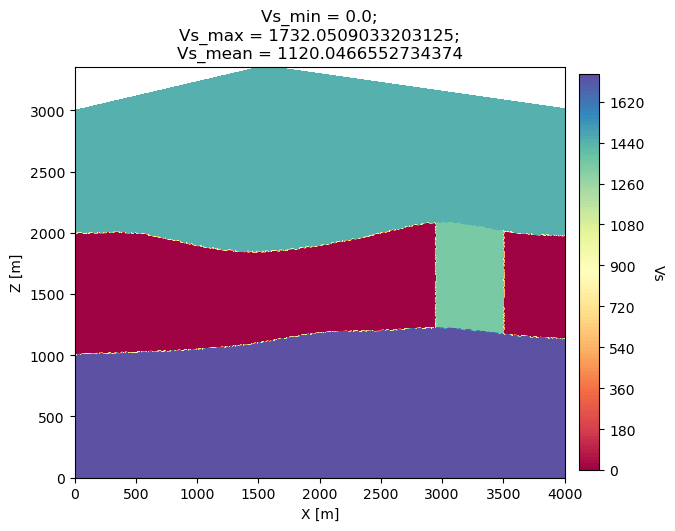

In [21]:
# We can use SeisFlows to plot this model
from seisflows.tools.specfem import Model

m = Model(path="DATA")
m.plot2d(parameter="vs")

From the model figure above, which shows shear wave velocities in a 2D domain, we can see that our model is defined by 3 distinct layers. The top layer, from Z=3500m down to Z=2000m, features a moderate velocity with topography at the surface (Z>3000m). The middle layer, from Z=2000m down to Z=1000m shows a low velocity zone with a high-velocity column (turquoise square). Finally, the bottom layer, from Z=1000m to Z=0m, features a realtively fast velocity. 

Each interface (topography and contact between layers), was defined in a file specified by `Par_file` parameter `interfacesfile`.

In [22]:
! seisflows sempar -P DATA/Par_file interfacesfile

interfacesfile:
../EXAMPLES/simple_topography_and_also_a_simple_fluid_layer/DATA/interfaces_simple_topo_curved.dat


In [23]:
! cat EXAMPLES/simple_topography_and_also_a_simple_fluid_layer/DATA/interfaces_simple_topo_curved.dat

# number of interfaces
 4
#
# for each interface below, we give the number of points and then x,z for each point
#
# interface number 1 (bottom of the mesh)
 2
 0 0
 5000 0
# interface number 2
 7
    0 1000
 1500 1100
 2000 1180
 2500 1200
 3000 1220
 3500 1170
 5000 1100
# interface number 3
 9
    0 2000
  500 2000
 1000 1900
 1500 1847
 2000 1900
 2500 2000
 3000 2090
 3500 2020
 5000 2000
# interface number 4 (topography, top of the mesh)
 8
    0 3000
  500 3000
 1000 3100
 1500 3350
 2000 3250
 2500 3180
 3000 3090
 5000 3000
#
# for each layer, we give the number of spectral elements in the vertical direction
#
# layer number 1 (bottom layer)
 20
# layer number 2
 20
# layer number 3 (top layer)
 20


### b) Synthetic waveforms

During the simulation, `xspecfem2D` initiated the `SOURCE` file at time 0. Over the course of the simulation, seismic waves propogated outward and were recorded at synthetic receiver locations defined by the `STATIONS` file. Each `STATION` therefore has a corresponding synthetic seismogram located in the *OUTPUT_FILES/* directory.

>__NOTE:__ Because we specified that we wanted displacement seismograms with `Par_file` parameter `seismotype`, our synthetics have the file extension `.semd`, where 'd' stands for displacement. Velocity seismograms would be extension'ed `.semv`.

In [24]:
! ls OUTPUT_FILES/*.semd

OUTPUT_FILES/AA.S0001.BXX.semd	OUTPUT_FILES/AA.S0012.BXX.semd
OUTPUT_FILES/AA.S0001.BXZ.semd	OUTPUT_FILES/AA.S0012.BXZ.semd
OUTPUT_FILES/AA.S0002.BXX.semd	OUTPUT_FILES/AA.S0013.BXX.semd
OUTPUT_FILES/AA.S0002.BXZ.semd	OUTPUT_FILES/AA.S0013.BXZ.semd
OUTPUT_FILES/AA.S0003.BXX.semd	OUTPUT_FILES/AA.S0014.BXX.semd
OUTPUT_FILES/AA.S0003.BXZ.semd	OUTPUT_FILES/AA.S0014.BXZ.semd
OUTPUT_FILES/AA.S0004.BXX.semd	OUTPUT_FILES/AA.S0015.BXX.semd
OUTPUT_FILES/AA.S0004.BXZ.semd	OUTPUT_FILES/AA.S0015.BXZ.semd
OUTPUT_FILES/AA.S0005.BXX.semd	OUTPUT_FILES/AA.S0016.BXX.semd
OUTPUT_FILES/AA.S0005.BXZ.semd	OUTPUT_FILES/AA.S0016.BXZ.semd
OUTPUT_FILES/AA.S0006.BXX.semd	OUTPUT_FILES/AA.S0017.BXX.semd
OUTPUT_FILES/AA.S0006.BXZ.semd	OUTPUT_FILES/AA.S0017.BXZ.semd
OUTPUT_FILES/AA.S0007.BXX.semd	OUTPUT_FILES/AA.S0018.BXX.semd
OUTPUT_FILES/AA.S0007.BXZ.semd	OUTPUT_FILES/AA.S0018.BXZ.semd
OUTPUT_FILES/AA.S0008.BXX.semd	OUTPUT_FILES/AA.S0019.BXX.semd
OUTPUT_FILES/AA.S0008.BXZ.semd	OUTPUT_FILES/AA.S0019.BXZ.semd
OUTPUT_F

Synthetic waveforms can be generated in a variety of formats. For simplicity we have chosen to output our synthetics in ACSII format. These ASCII files are two columns, representing time and amplitude, respectively.

In [25]:
# The first 10 lines of a seismogram
! head -10 OUTPUT_FILES/AA.S0001.BXX.semd

 -0.12000000000000000          0.0000000000000000     
 -0.11889999999999999          0.0000000000000000     
 -0.11780000000000000          0.0000000000000000     
 -0.11670000000000000          0.0000000000000000     
 -0.11559999999999999          0.0000000000000000     
 -0.11449999999999999          0.0000000000000000     
 -0.11340000000000000          0.0000000000000000     
 -0.11230000000000000          0.0000000000000000     
 -0.11119999999999999          0.0000000000000000     
 -0.11009999999999999          0.0000000000000000     


Text(0, 0.5, 'Displacement [m]')

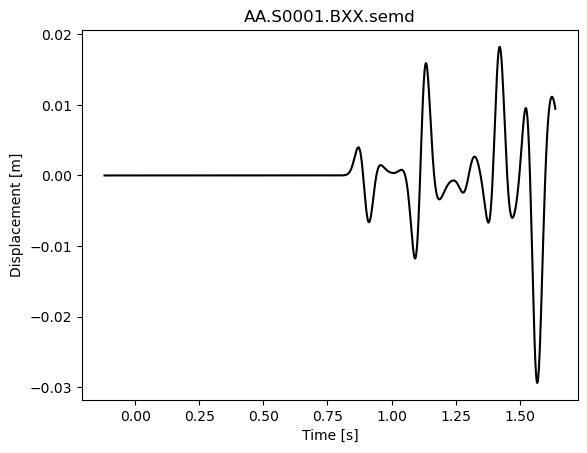

In [26]:
# We can easily plot these using NumPy and Matplotlib
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("OUTPUT_FILES/AA.S0001.BXX.semd", dtype=float)
plt.plot(data[:,0], data[:,1], c="k")
plt.title("AA.S0001.BXX.semd")
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

In [27]:
# SeisFlows also has a simple command line tool to plot seismograms using ObsPy
! seisflows plotst OUTPUT_FILES/AA.S0001.BXX.semd --savefig AA.S0001.BXX.semd.png

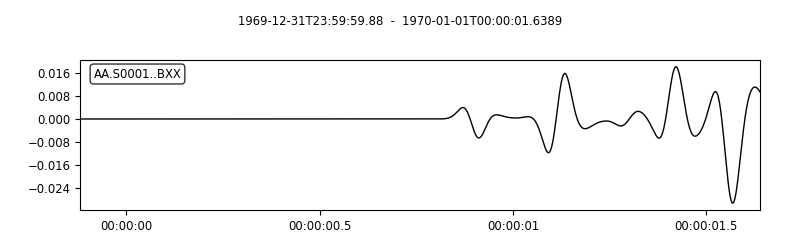

In [28]:
# We need to use IPython to visualize these figures in the notebook
from IPython.display import Image
Image("AA.S0001.BXX.semd.png")

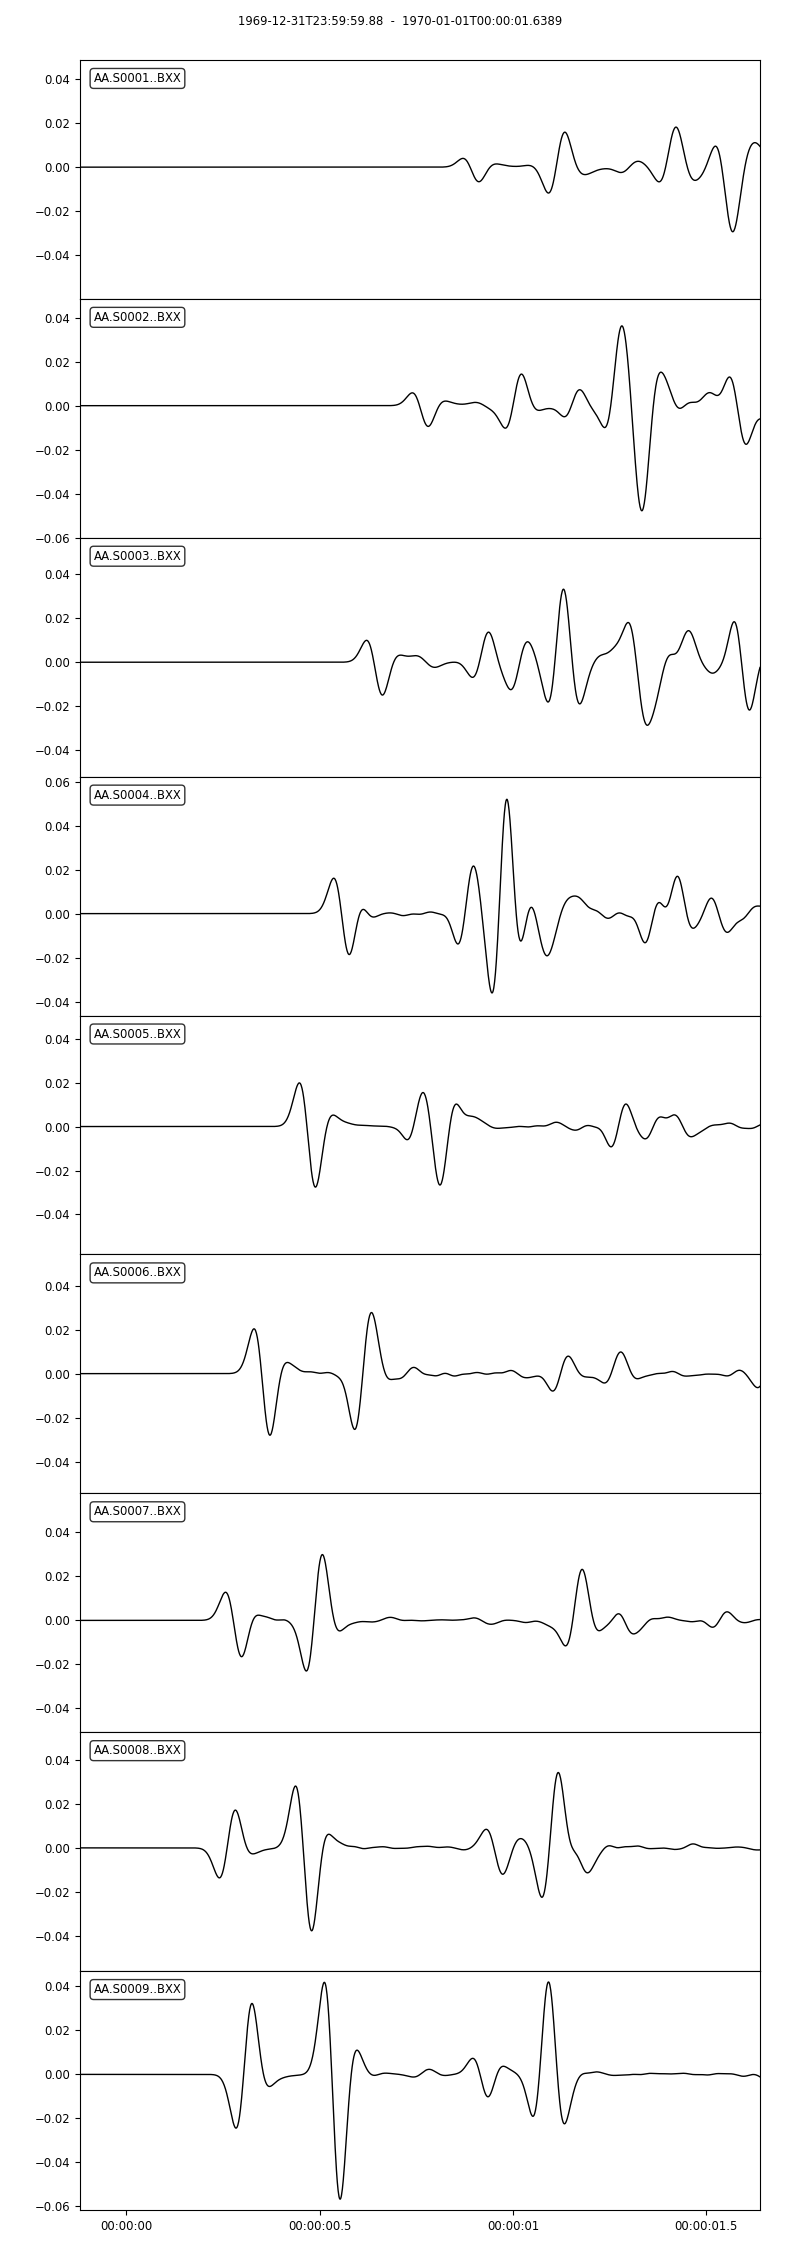

In [29]:
# We can use wildcards to plot multiple waveforms at once
! seisflows plotst OUTPUT_FILES/AA.S000?.BXX.semd --savefig AA.S000n.BXX.semd.png
Image("AA.S000n.BXX.semd.png")

### c) SPECFEM2D Figures

`xspecfem2D` also generates snapshots of the forward wavefield. These are automatically generated during a simulation as .jpg files. The `Par_file` parameter `NTSTEP_BETWEEN_OUTPUT_IMAGES` controls how often it generates figures during a simulation. We can see below that `DT`=.0011, so we output images every 0.11s of simulation time. 

In [30]:
! seisflows sempar -P DATA/Par_file ntstep_between_output_images
! seisflows sempar -P DATA/Par_file dt

NTSTEP_BETWEEN_OUTPUT_IMAGES: 100
DT: 0.0011


In [31]:
! ls OUTPUT_FILES/*.jpg

OUTPUT_FILES/forward_image000000005.jpg
OUTPUT_FILES/forward_image000000100.jpg
OUTPUT_FILES/forward_image000000200.jpg
OUTPUT_FILES/forward_image000000300.jpg
OUTPUT_FILES/forward_image000000400.jpg
OUTPUT_FILES/forward_image000000500.jpg
OUTPUT_FILES/forward_image000000600.jpg
OUTPUT_FILES/forward_image000000700.jpg
OUTPUT_FILES/forward_image000000800.jpg
OUTPUT_FILES/forward_image000000900.jpg
OUTPUT_FILES/forward_image000001000.jpg
OUTPUT_FILES/forward_image000001100.jpg
OUTPUT_FILES/forward_image000001200.jpg
OUTPUT_FILES/forward_image000001300.jpg
OUTPUT_FILES/forward_image000001400.jpg
OUTPUT_FILES/forward_image000001500.jpg
OUTPUT_FILES/forward_image000001600.jpg


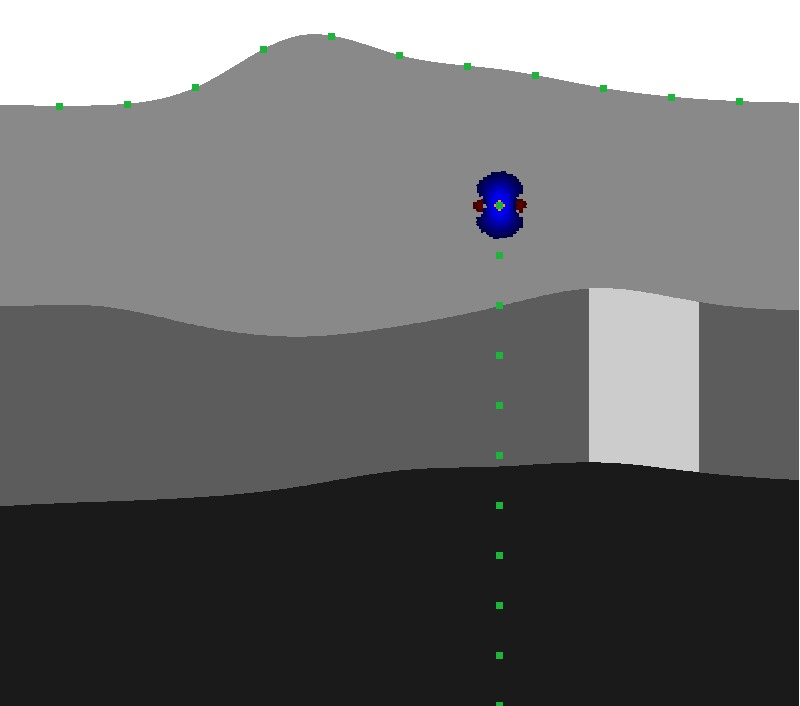

In [32]:
# Forward wavefield at NSTEP=100, T=.11s
Image("OUTPUT_FILES/forward_image000000100.jpg")

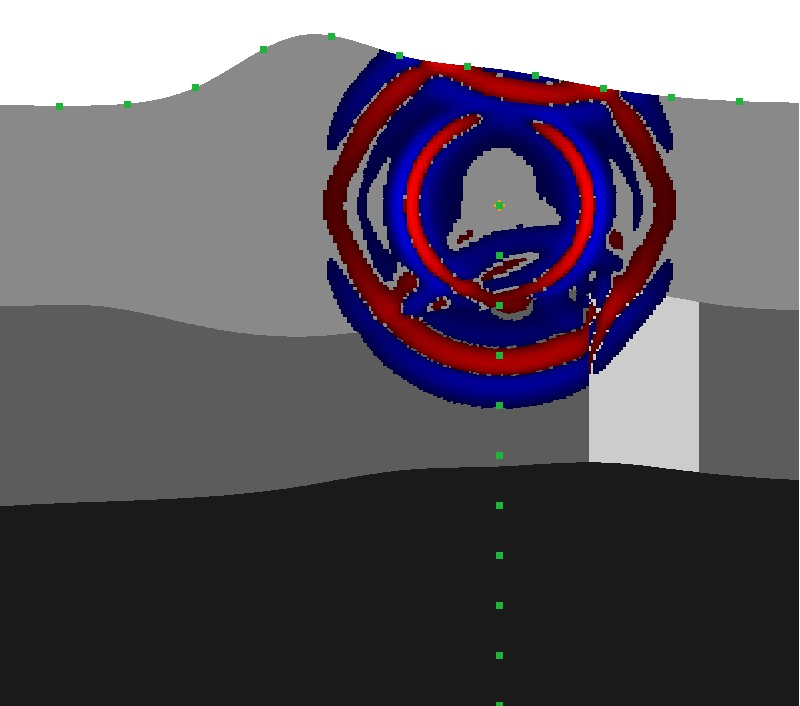

In [33]:
# Forward wavefield at NSTEP=400, T=.44s
Image("OUTPUT_FILES/forward_image000000400.jpg")

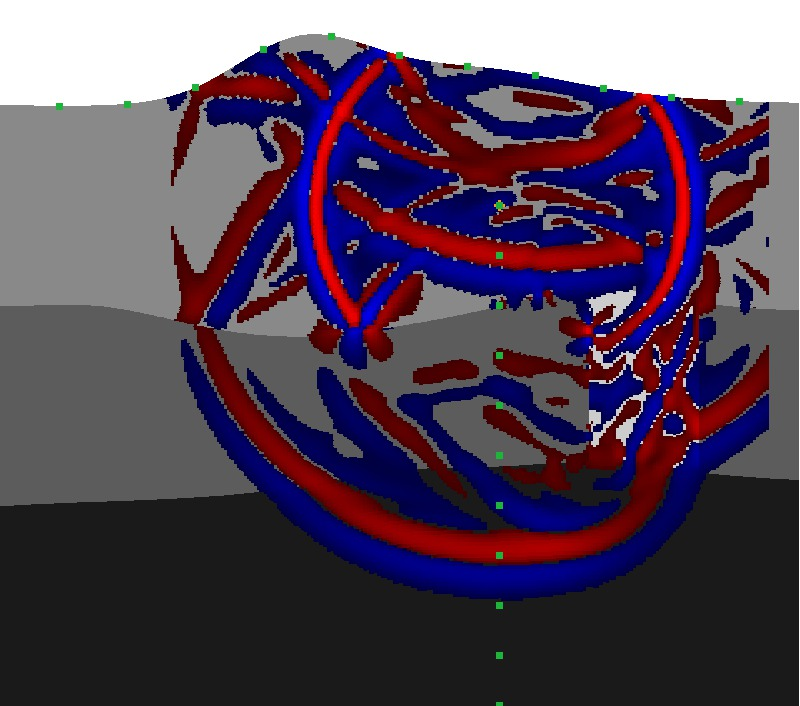

In [34]:
# Forward wavefield at NSTEP=700, T=.77s
Image("OUTPUT_FILES/forward_image000000700.jpg")